# Определение закономерностей, влияющих на успешность игры

Интернет-магазин "Стримчик", который продаёт по всему миру компьютерные игры, хочет выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

- **С чем будем работать**:
  - Из открытых источников доступны исторические данные (до 2016 года) о продажах игр, оценки пользователей и экспертов, жанры и платформы.
- **Основные этапы**:
  - Подготовка данных (обработка пропусков, приведение данных к нужному типу, проведение рассчётов, необходимых для дальнейшего исследования.
  - Проведение исследовательского анализа (сколько игр выпускалось в разные годы, как менялись продажи по платформам, выделение актуального периода, ориентируясь на который, можно строить прогнозы).
  - Составление портрета пользователя по регионам (популярные платформы, жанры, продажи)
  - Формулирование и проверка гипотез

## Изучение данных

Импортируем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

%matplotlib inline

Первым шагом, рассмотрим данные в таблице. Прочитаем её из .csv-файла и выведем общую информацию.

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Столбец с оценками пользователей - в формате объекта. В нём могут быть текстовые, или смешанные числовые и нечисловые значения. Будем иметь это ввиду.

Посмотрим на первые пять строк таблицы.

In [4]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


В первом приближении видим, что имена столбцов требуют приведения к нижнему регистру. Также, столбец с годом выпуска, неплохо привести к целочисленному значению.

Рассмотрим базовую информацию по **нечисловым** значениям в таблице.

In [5]:
games.describe(exclude=np.number)

,Name,Platform,Genre,User_Score,Rating
count,16713,16715,16713,10014,9949
unique,11559,31,12,96,8
top,Need for Speed: Most Wanted,PS2,Action,tbd,E
freq,12,2161,3369,2424,3990


Вот, мы уже имеем на руках первую статистику по таблице:
- самая часто упоминаемая игра - Need for Speed: Most Wanted (12 раз)
- топовая платформа по количеству выпущенных игр - PlayStation 2 (2161 строка)
- наиболее популярный жанр - Action (3369 строк)
- самый распространённый рейтинг - 'Е' (3990 строк)

И тут мы, как раз, видим, почему столбец с оценками пользователей, имеет смешанный формат данных. Наиболее распространённое значение в нём - 'tbd'. Что же это такое? Обратимся к открытым источникам. Например, к сайту Metacritic.

Metacritic (с англ. — «мета-критика») — англоязычный сайт-агрегатор, собирающий отзывы о музыкальных альбомах, играх, фильмах, телевизионных шоу, DVD-дисках и мобильных играх. На основании собранных отзывов сайт высчитывает средний рейтинг продукта, который активно используется в журналистике, индустрии компьютерных игр и бизнесе, в частности, для предсказания коммерческого успеха недавно выпущенной игры. (Данные из Википедии.)

По терминологии сайта Metacritic, 'tbd' это:

To Be Determined.

To help ensure that METASCORES accurately reflect the reviews given by critics for any particular movie, game, television show or album, we do not display a METASCORE for those items that do not have at least four (4) reviews in our database. Once this minimum number of reviews is reached, the METASCORE will display.


Если перевести на русский - сайт не даёт продукту оценку, если количество отзывов не превышает, по-меньшей мере, четырёх. Следовательно, в наших данных, значение 'tbd' относится к играм, которые не собрали достаточное количество пользовательских оценок, либо вовсе, не было ресурса, где было бы возможным оценку поставить - например, игра выпущена в начале 80-х годов прошлого века.

По ходу исследования решим, что делать с этим значением в таблице.

Теперь **базовые статистики**.

In [6]:
games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


- данные в таблице начинаются с 1980 года и заканчиваются 2016-м
- самый большой рынок - Североамериканский, с его средними продажами в 260 тыс. копий игр
- минимальная оценка критиков - 13 из 100, макисмальная - 98.

## Подготовка данных

Для начала, приведём названия столбцов к **нижнему регистру**.

In [7]:
games.columns = games.columns.str.lower()

In [8]:
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Проверим таблицу на **пропуски**.

In [9]:
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

В столбце с названием игры и с названием жанра - по два пропуска. Их можно смело удалить, но, для разогрева, посмотрим что в них.

In [10]:
games.loc[games.name.isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Две практически пустых строки. Но, в одной из них, указан год выпуска и продажи по Северной Америке в почти два миллиона копий. Сделаем срез таблицы по платформе и году.

In [11]:
games.loc[(games.platform == 'GEN') & (games.year_of_release == 1993)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
7885,Shining Force II,GEN,1993.0,Strategy,0.00,0.00,0.19,0.00,NaN,NaN,NaN
8893,Super Street Fighter II,GEN,1993.0,Fighting,0.00,0.00,0.15,0.00,NaN,NaN,NaN
11986,Ecco: The Tides of Time,GEN,1993.0,Adventure,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12098,Street Fighter II': Special Champion Edition (...,GEN,1993.0,Action,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12264,Streets of Rage 3,GEN,1993.0,Action,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12984,Dynamite Headdy,GEN,1993.0,Platform,0.00,0.00,0.05,0.00,NaN,NaN,NaN
13343,Beyond Oasis,GEN,1993.0,Role-Playing,0.00,0.00,0.05,0.00,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


По полученным данным, пустая строка выглядит как общие продажи за год по платформе GEN. 

Заполним название "продажами_за_год", а жанр "прочим".

In [12]:
games.loc[games.name.isna(), 'name'] = 'sales_per_year'
games.loc[games.genre.isna(), 'genre'] = 'Misc'
games[['name', 'genre']].isna().sum()

name     0
genre    0
dtype: int64

Следующий столбец - год выпуска.

In [13]:
games.year_of_release.isna().sum()

269

Чуть менее 2% от общих данных. Так же можно удалить. Но, давайте посмотрим хотя бы на игры "миллионники" по Североамериканскому рынку.

In [14]:
games.loc[(games.year_of_release.isna()) & (games.na_sales >= 1)].sort_values('na_sales', ascending=False)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
805,Rock Band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T
1506,Adventure,2600,NaN,Adventure,1.21,0.08,0.00,0.01,NaN,NaN,NaN
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T


Madden NFL 2004 - с более чем четырьмя миллионами копий и, следующая после него, Space Invaders. А это уже икона видеоигр, из далёкого 1978 года. Давайте отдадим ей должное и оставим в нашей таблице :)

In [15]:
games.loc[(games.name == 'Space Invaders') & (games.platform == '2600'), 'year_of_release'] = 1978
games.loc[games.name == 'Madden NFL 2004', 'year_of_release'] = 2003 #год выпуска взят из открытых источников
games[games.name.isin(['Space Invaders', 'Madden NFL 2004'])].head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,2003.0,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
609,Space Invaders,2600,1978.0,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


Остальные строки с пропущенными годами - удаляем.

In [16]:
games.dropna(subset=['year_of_release'], inplace=True)
games.year_of_release.isna().sum()

0

К оставшимся пропускам мы ещё вернёмся, но, для начала, **приведём данные в столбцах, к нужному нам формату**. 

Как мы помним, столбец с оценками пользователей, находится в формате объекта, а нам с ним работать и вести подсчёты. А в формате объекта он находится благодаря 'tbd' - игре без оценки.

Посмотрим, сколько всего 'tbd'.

In [17]:
games[games.user_score == 'tbd'].user_score.count()

2376

Чтобы привести столбец к интересующему нас формату "числа с плавающей запятой", приравняем 'tbd' к нулю - как игру с отсутствующей оценкой (далее мы рассмотрим, к чему это приведёт).

Также, для удобства, сделаем "год выпуска" целочисленным.

In [18]:
games.loc[games.user_score == 'tbd', 'user_score'] = 0
games = games.astype({'year_of_release': 'int64', 'user_score': 'float64'})
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Быстрая проверка по 'user_score'.

In [19]:
games.user_score.dtype

dtype('float64')

In [20]:
games[games.user_score == 0].user_score.count()

2377

Данный результат нас устраивает.

Вспомним, что ещё **по пропускам**.

In [21]:
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8464
user_score         6608
rating             6679
dtype: int64

Займёмся оценками критиков и пользователей. Сравним статистики по столбцам.

In [22]:
games[['critic_score', 'user_score']].describe()

,critic_score,user_score
count,7984.000000,9840.000000
mean,68.997495,5.405722
std,13.922001,3.317895
min,13.000000,0.000000
25%,60.000000,2.400000
50%,71.000000,6.900000
75%,79.000000,8.000000
max,98.000000,9.700000


Минимальная оценка критиков - 13. Нулевых оценок в данном столбце нет. 

По аналогии можно подойти к оценкам пользователей, где '0' - это наша замена 'tbd', и нулевую оценку пользователи не ставят. Проверим это.

Есть ли шанс не целой, околонулевой оценки?

In [23]:
games.query('0 < user_score < 1').user_score.count()

12

Он есть. Поэтому, смело принимаем ноль, как отсутствующую оценку и заменим пропуски в критиках и юзерах.

In [24]:
games.loc[(games.critic_score.isna()) | (games.user_score.isna()), ['critic_score', 'user_score']] = 0
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.0,0.0,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,NaN


Мы рассматривали возможность замены пропусков средней оценкой по столбцу. Но, ввиду того, что такая оценка получается слишком высокой, и может повлиять на дальнейшее исследование, остановились на заполнении нулём. Далее будем это учитывать.

Для работы с пропусками в рейтинге, узнаем, какие значения существуют и сколько их.

In [25]:
games.rating.value_counts()

E       3922
T       2905
M       1536
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64

Рейтинги присваиваются Entertainment Software Rating Board (ESRB) — негосударственной организацией, основное направление деятельности которой — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде.

Наиболее распространён рейтинг 'E' ('Everyone') - по терминологии ESRB, вполне подходит для возрастной категории от 6 лет. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера.

Более ранний 'K-A', производные 'E10+' и 'EC', для удобства приравняем к 'E'.

На втором месте рейтинг 'T' ('Teen') - игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.

Далее рейтинг 'M' ('Mature') - материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории.

И единичный 'AO' - только для взрослых 18+ лет и 'RP' - игра без рейтинга. 

Посмотрим, что это за единичные случаи.

In [26]:
games[games.rating.isin(['AO', 'RP'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
875,Grand Theft Auto: San Andreas,XB,2005,Action,1.26,0.61,0.0,0.09,93.0,8.6,AO
14270,Supreme Ruler: Cold War,PC,2011,Strategy,0.00,0.03,0.0,0.01,63.0,6.8,RP


In [27]:
games[games.name == 'Grand Theft Auto: San Andreas']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
17,Grand Theft Auto: San Andreas,PS2,2004,Action,9.43,0.40,0.41,10.57,95.0,9.0,M
875,Grand Theft Auto: San Andreas,XB,2005,Action,1.26,0.61,0.00,0.09,93.0,8.6,AO
2115,Grand Theft Auto: San Andreas,PC,2005,Action,0.00,0.93,0.00,0.04,93.0,8.9,M
10311,Grand Theft Auto: San Andreas,X360,2008,Action,0.08,0.02,0.00,0.01,0.0,0.0,M


'Grand Theft Auto: San Andreas' - десять миллионов продаж и максимальные рейтинги. На других платформах она выходила под рейтингом 'M'. Перекидываем в него 'AO'. 

Одинокую стратегию забросим в рейтинг 'E'. Как правило, игры этого жанра подходят для всех.

Пропуски в столбце заполним значением 'RP' - игры без рейтинга. Нет значения - нет рейтинга.

In [28]:
games.loc[games.rating == 'AO', 'rating'] = 'M'
games.loc[games.rating.isin(['E10+', 'EC', 'K-A']), 'rating'] = 'E'
games.loc[games.rating.isna(), 'rating'] = 'RP'
games.rating.value_counts()

RP    6680
E     5326
T     2905
M     1537
Name: rating, dtype: int64

Любопытно, игры без рейтинга поднялись в топ. 

In [29]:
games.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

In [30]:
games.dtypes

name                object
platform            object
year_of_release      int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object

Пропуски заполнены, данные приведены к нужному типу.

Посчитаем **суммарные продажи** во всех регионах и добавим их в отдельный столбец.

In [31]:
games['total_sales'] = games.iloc[:, 4:8].sum(axis=1)
games.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.0,0.0,RP,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,RP,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,0.0,0.0,RP,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,0.0,0.0,RP,28.31


Всё необходимое у нас на руках. Пора переходить к анализу.

## Исследовательский анализ данных

Посмотрим, сколько игр выпускалось **в разные годы**. Построим график.

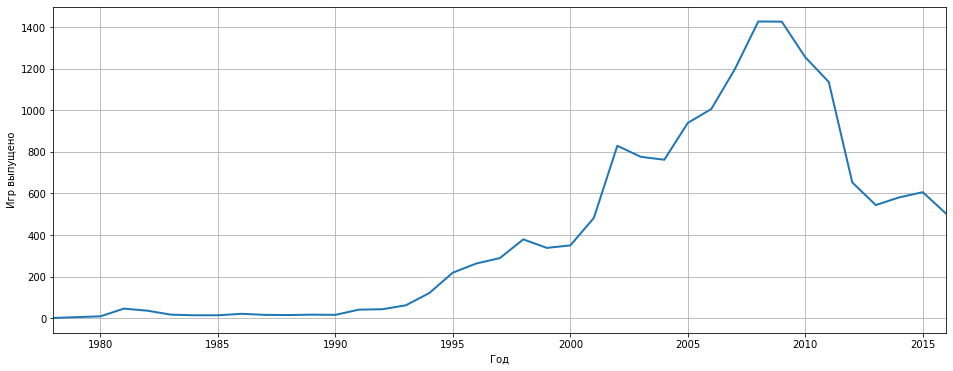

In [32]:
plt.figure(figsize=(16, 6))
games.groupby('year_of_release').name.count().plot(lw=2, grid=True)
plt.xlim(1978, 2016)
plt.xlabel('Год')
plt.ylabel('Игр выпущено')
plt.show()

Как видим, ощутимый подъём начинается после 1995 года, а основной всплеск пришёлся на начало нулевых.

Узнаем, что происходило на рынке платформ за всё это время.

In [33]:
platform_sales = games.groupby('platform')[['total_sales']].sum().\
sort_values('total_sales', ascending=False).reset_index()
platform_sales.head(11)

,platform,total_sales
0,PS2,1238.80
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


Лидирующее место занимает PlayStation 2, с общими продажами более миллиарда копий за всё время.

Сделаем **срез по топ-10 платформ**.

In [34]:
platform_top_ten = platform_sales.iloc[:10, :1]
platform_top_ten

,platform
0,PS2
1,X360
2,PS3
3,Wii
4,DS
5,PS
6,PS4
7,GBA
8,PSP
9,3DS


Разобьём продажи внутри платформ по годам.

In [35]:
platform_data = games.groupby(['year_of_release', 'platform']).agg({'total_sales':'sum'}).\
sort_values(by='total_sales', ascending=False).reset_index()
platform_data_years = pd.merge(platform_data, platform_top_ten)
platform_data_years.head()

,year_of_release,platform,total_sales
0,2004,PS2,211.81
1,2002,PS2,205.38
2,2003,PS2,189.55
3,2001,PS2,166.43
4,2005,PS2,160.66


Построим график продаж.

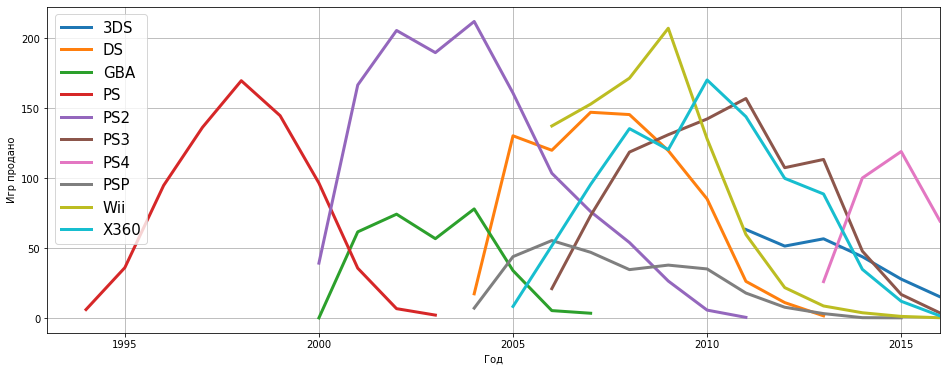

In [36]:
platform_data_years.pivot_table(index='year_of_release', columns='platform', values='total_sales').\
plot(lw=3, figsize=(16, 6), grid=True)
plt.xlim(1993, 2016)
plt.xlabel('Год')
plt.ylabel('Игр продано')
plt.legend(fontsize=15)
plt.show()

Вот мы и узнали причину подъёма продаж - в 1995 году выходит Sony PlayStation, которая потянула за собой рынок видеоигр. Следом, в 2000 году, появилась на свет PlayStation 2 - наш лидер по проданным играм. 

Далее, после середины нулевых, видно как рынок начинает наполнятся разнообразными, не менее успешными чем предыдущие, платформами.

Как видно из графика, полноценное время жизни платформы - около шести лет. Пик продаж приходится на два-три года. 


Воспользуемся этим фактором и попытаемся построить прогноз на 2017 год: 
- какие платформы лидируют по продажам
- какие платформы потенциально прибыльные

**Сделаем срез с 2012 по 2016 год**. Нам достаточно этого периода, для составления прогноза.

In [37]:
platform_actual = pd.merge(platform_data, platform_sales, on='platform')
platform_actual.drop('total_sales_y', axis=1, inplace=True)
platform_actual.columns = ['year_of_release', 'platform', 'total_sales']
platform_actual = platform_actual.query('2012 <= year_of_release')
platform_actual.reset_index(drop=True, inplace=True)
platform_actual.head()

,year_of_release,platform,total_sales
0,2012,Wii,21.71
1,2013,Wii,8.59
2,2014,Wii,3.75
3,2015,Wii,1.14
4,2016,Wii,0.18


Построим график продаж.

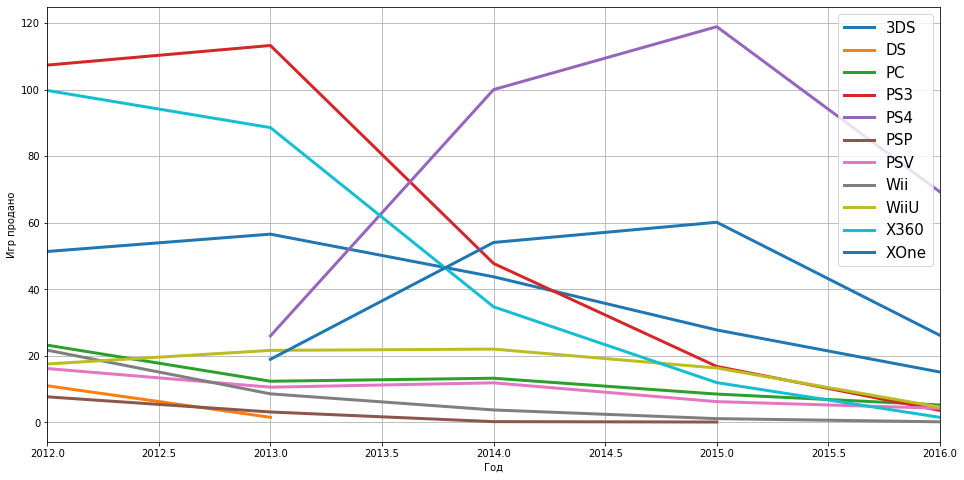

In [38]:
platform_actual.pivot_table(index='year_of_release', columns='platform', values='total_sales').\
plot(lw=3, figsize=(16, 8), grid=True)
plt.xlim(2012, 2016)
plt.xlabel('Год')
plt.ylabel('Игр продано')
plt.legend(fontsize=15)
plt.show()

Видно, как уходят старые платформы и на их место, приходят новые. Например, на смену PlayStation 3 и Х-Box 360, в 2013 году пришли PS4 и Х-Box One. Параллельно, не сдаёт позиций компания Nintendo, со своими 3DS и WiiU. Где-то внизу, не стремясь к высотам, занимает свою нишу персональный компьютер.

Узнаем **лидеров продаж** за этот период.

In [40]:
platform_actual.groupby('platform', as_index=False).total_sales.sum().sort_values('total_sales', ascending=False)

,platform,total_sales
4,PS4,314.14
3,PS3,288.79
9,X360,236.54
0,3DS,194.61
10,XOne,159.32
8,WiiU,82.19
2,PC,62.65
6,PSV,49.18
7,Wii,35.37
1,DS,12.55


Старички ещё не сдают позиций, но все мы знаем, что им на смену пришли новые платформы. 
Выберем из них потенциально прибыльные:
- PlayStation 4 - как новичок, который сразу занял первое место топа
- X-Box One - уступает по продажам своему прародителю, но за ним будущее 
- Nintendo 3DS - в первой пятёрке 
- Nintendo WiiU - не отстаёт 
- PC - в первой десятке, занимает свою нишу долгие годы и на смену ему, как платформе, пока ничего не предвидится

Создадим **актуальную таблицу** по продажам игр, за интересующий нас период.

In [41]:
games_actual = games.query('2012 <= year_of_release')
games_actual.reset_index(drop=True, inplace=True)
games_actual.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,0.0,0.0,RP,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,0.0,0.0,RP,14.60
4,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


**Построим «ящики с усами»** по глобальным продажам игр, в разбивке по платформам.

**PlayStation 4**

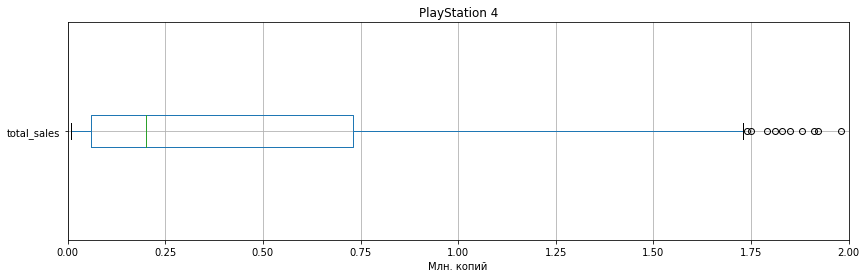

In [42]:
ps4_data = games_actual.loc[games_actual.platform == 'PS4']
ps4_data.reset_index(drop=True, inplace=True)
plt.figure(figsize=(14, 4))
ps4_data.total_sales.plot(kind='box', grid=True, vert=False)
plt.xlim(0, 2)
plt.title('PlayStation 4')
plt.xlabel('Млн. копий')
plt.show()

Датасет скошен вправо. Это означает, что несмотря на медиану ниже 250 тысяч, присутствует длинный "ус" с более высокими продажами, достигающими полутора миллионов копий. После значения в 1 млн. 700 тысяч, начинаются выбросы с хитами продаж, превышающими 2 млн. Основная же масса игр на этой платформе, лежит в пределах тиража, примерно, от 100 до 750 тысяч.

**X-Box One**

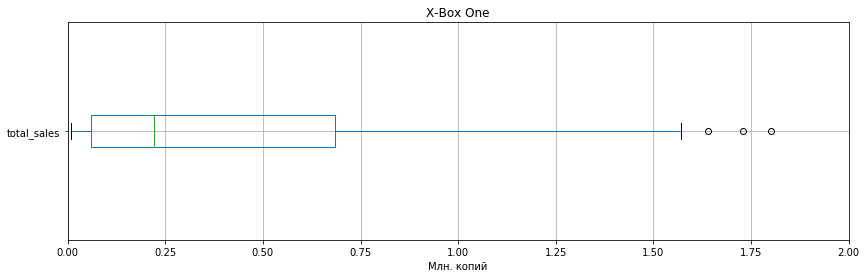

In [43]:
xone_data = games_actual.loc[games_actual.platform == 'XOne']
xone_data.reset_index(drop=True, inplace=True)
plt.figure(figsize=(14, 4))
xone_data.total_sales.plot(kind='box', grid=True, vert=False)
plt.xlim(0, 2)
plt.title('X-Box One')
plt.xlabel('Млн. копий')
plt.show()

У следующего новичка на рынке платформ схожая ситуация. Скошенный вправо датасет, близкие медианные значения и основной объём продаж, правый "ус" переваливает за полтора миллиона. Видимо, производители игр для этих платформ и маркетологи, работают примерно по одному плану. Однако, несмотря на это, XOne уступает рынок почти в два раза, хотя и стартовал вместе с PS4. Возможно, стоит выпускать больше хитов, или налечь на массовость. Компании Microsoft есть над чем подумать.

**Nintendo 3DS**

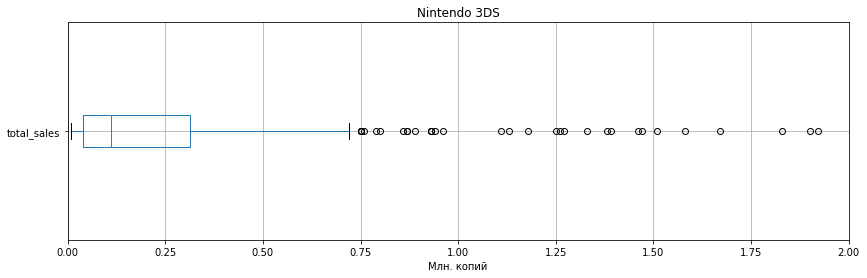

In [44]:
n3ds_data = games_actual.loc[games_actual.platform == '3DS']
n3ds_data.reset_index(drop=True, inplace=True)
plt.figure(figsize=(14, 4))
n3ds_data.total_sales.plot(kind='box', grid=True, vert=False)
plt.xlim(0, 2)
plt.title('Nintendo 3DS')
plt.xlabel('Млн. копий')
plt.show()

Низкие медианные продажи, по сравнению с PS4 и XOne. Гораздо более низкое положение третьего квартиля, приближенное к медианным продажам предыдущих платформ. Там где у них всё только начинается, здесь уже заканчивается. Что же выводит эту платформу на четвёртое место в нашем топе? Судя по хвосту из выбросов - хиты продаж с высокими тиражами, разлетающиеся как горячие пирожки. Nintendo 3DS - это портативная консоль. Каждый пользователь хочет иметь у себя в кармане хитовую игру и приобщаться к ней в любое удобное время, в любом удобном месте.

**Nintendo WiiU**

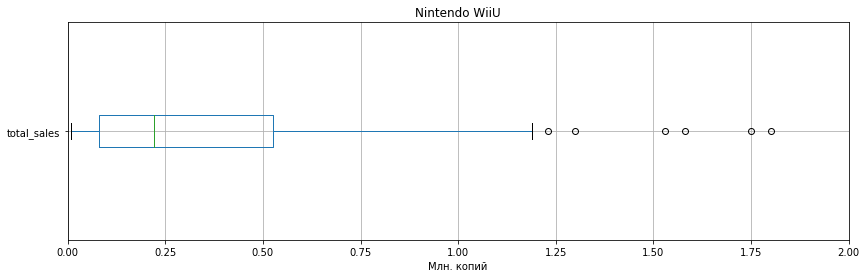

In [45]:
wiiu_data = games_actual.loc[games_actual.platform == 'WiiU']
wiiu_data.reset_index(drop=True, inplace=True)
plt.figure(figsize=(14, 4))
wiiu_data.total_sales.plot(kind='box', grid=True, vert=False)
plt.xlim(0, 2)
plt.title('Nintendo WiiU')
plt.xlabel('Млн. копий')
plt.show()

Ещё один представитель портативного семейства. Более широкий размах и медиана как у стационарных "коллег", не позволили данной консоли обогнать, или приблизиться к своему собрату 3DS. Разница более чем в сто миллионов проданных копий внушительна. Однако, платформа занимает свою нишу и на общем графике идёт практически параллельно с 3DS. Нельзя её списывать со счетов.

**PC**

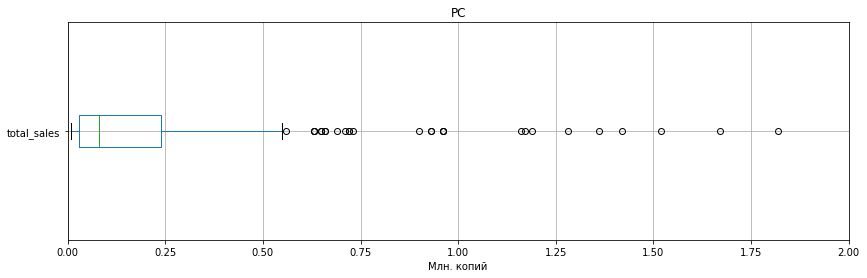

In [46]:
pc_data = games_actual.loc[games_actual.platform == 'PC']
pc_data.reset_index(drop=True, inplace=True)
plt.figure(figsize=(14, 4))
pc_data.total_sales.plot(kind='box', grid=True, vert=False)
plt.xlim(0, 2)
plt.title('PC')
plt.xlabel('Млн. копий')
plt.show()

По общим продажам, рынок PC выдаёт самые скромные показатели из выбранных нами платформ. Однако, это компенсируется стабильностью. Медиана на уровне более успешной 3DS и достаточно длинный хвост выбросов, что говорит о достаточном количестве игр-хитов, выходящих на PC. Не смотря ни на что, персональный компьютер по-прежнему остаётся актуальным и востребованным. С 1980-х годов сменились многие поколения платформ и консолей, а PC никуда не делся и, поэтому, мы включили его в наш топ.

Посмотрим, как влияют на продажи внутри самой популярной платформы, **отзывы пользователей и критиков**. Построим диаграмму рассеяния и узнаем **корреляцию** между отзывами и продажами.

**PS4 - оценка критиков**.

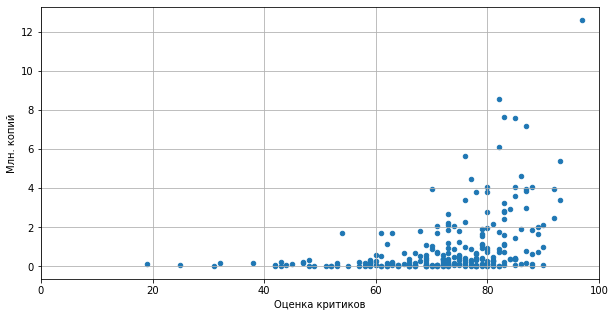

In [47]:
#здесь и далее, уберём игры без оценок
ps4_data.loc[ps4_data.critic_score > 0].\
plot(x='critic_score', y='total_sales', kind='scatter', grid=True, figsize=(10, 5))
plt.xlabel('Оценка критиков')
plt.ylabel('Млн. копий')
plt.xlim(0, 100)
plt.show()

Посчитаем **коэффициент корреляции Пирсона**. Он помогает определить наличие линейной связи между величинами. Чем ближе коэффициент корреляции Пирсона к 1 или -1, тем теснее линейная взаимосвязь. Если значение близко к нулю, значит линейная связь слабая, либо отсутствует вовсе.

In [48]:
ps4_crit_corr = ps4_data.loc[ps4_data.critic_score > 0]
ps4_crit_corr.critic_score.corr(ps4_crit_corr.total_sales)

0.40600211593500984

Как мы видим из диаграммы, линейной зависимости между оценками и продажами, практически нет. Значения растянуты вдоль "нулевой" оси продаж. Также, отсутствие прямой зависимости подтверждает коэффициент корреляции в 0.4 - показатель ненулевой, но и не решающий (хотя, мы наблюдаем повышение продаж у некоторых игр, с высокими оценками). 

**PS4 - оценка пользователей**.

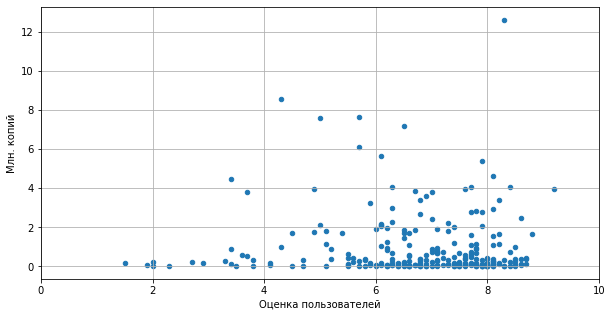

In [49]:
ps4_data.loc[ps4_data.user_score > 0].\
plot(x='user_score', y='total_sales', kind='scatter', grid=True, figsize=(10, 5))
plt.xlabel('Оценка пользователей')
plt.ylabel('Млн. копий')
plt.xlim(0, 10)
plt.show()

In [50]:
ps4_user_corr = ps4_data.loc[ps4_data.user_score > 0]
ps4_user_corr.user_score.corr(ps4_user_corr.total_sales)

-0.03362497596528878

Линейная зависимость между оценками пользователей и продажами отсутствует.

Сравним с **парой других платформ**.

**Nintendo 3DS - оценка критиков**.

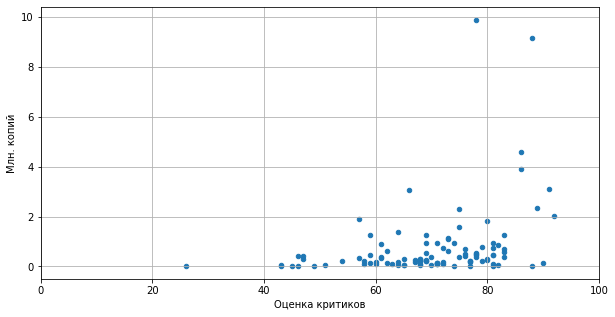

In [51]:
n3ds_data.loc[n3ds_data.critic_score > 0].\
plot(x='critic_score', y='total_sales', kind='scatter', grid=True, figsize=(10, 5))
plt.xlabel('Оценка критиков')
plt.ylabel('Млн. копий')
plt.xlim(0, 100)
plt.show()

In [52]:
n3ds_critic_corr = n3ds_data.loc[n3ds_data.critic_score > 0]
n3ds_critic_corr.critic_score.corr(n3ds_critic_corr.total_sales)

0.3208028695360785

Зависимость практически отсутствует.

**Nintendo 3DS - оценка пользователей**.

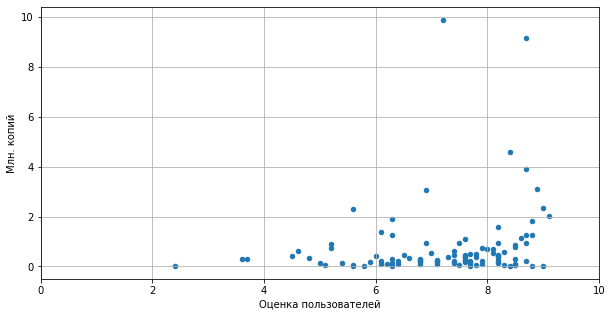

In [53]:
n3ds_data.loc[n3ds_data.user_score > 0].\
plot(x='user_score', y='total_sales', kind='scatter', grid=True, figsize=(10, 5))
plt.xlabel('Оценка пользователей')
plt.ylabel('Млн. копий')
plt.xlim(0, 10)
plt.show()

In [54]:
n3ds_user_corr = n3ds_data.loc[n3ds_data.user_score > 0]
n3ds_user_corr.user_score.corr(n3ds_user_corr.total_sales)

0.20181255007655283

Зависимость отсутствует.

**PC - оценка критиков**.

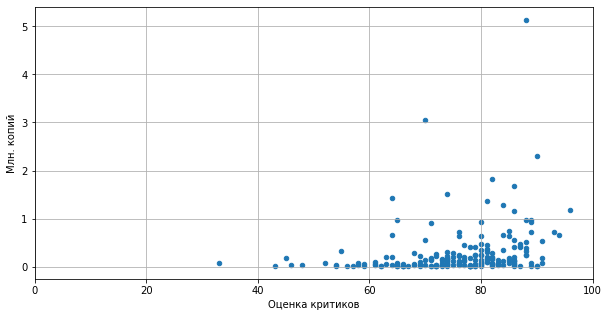

In [55]:
pc_data.loc[pc_data.critic_score > 0].\
plot(x='critic_score', y='total_sales', kind='scatter', grid=True, figsize=(10, 5))
plt.xlabel('Оценка критиков')
plt.ylabel('Млн. копий')
plt.xlim(0, 100)
plt.show()

In [56]:
pc_critic_corr = pc_data.loc[pc_data.critic_score > 0]
pc_critic_corr.critic_score.corr(pc_critic_corr.total_sales)

0.23600773618792362

На PC, зависимость продаж от оценок критиков, также отсутствует.

**PC - оценка пользователей**.

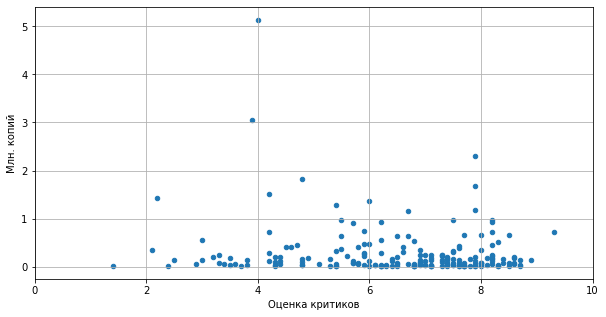

In [57]:
pc_data.loc[pc_data.user_score > 0].\
plot(x='user_score', y='total_sales', kind='scatter', grid=True, figsize=(10, 5))
plt.xlabel('Оценка критиков')
plt.ylabel('Млн. копий')
plt.xlim(0, 10)
plt.show()

In [58]:
pc_user_corr = pc_data.loc[pc_data.user_score > 0]
pc_user_corr.critic_score.corr(pc_user_corr.total_sales)

0.23600773618792362

Зависимости нет.

Далее, посмотрим на общее **распределение игр по жанрам**. 

In [59]:
games_actual.groupby('genre', as_index=False).total_sales.sum().sort_values('total_sales', ascending=False)

,genre,total_sales
0,Action,441.12
8,Shooter,304.73
7,Role-Playing,192.80
10,Sports,181.07
3,Misc,85.04
4,Platform,61.00
6,Racing,53.50
2,Fighting,44.49
9,Simulation,35.12
1,Adventure,29.43


- С большим отрывом выделяется четвёрка лидеров: жанры Action, Shooter, RPG и спортивные игры. 
- В аутсайдерах головоломки и стратегии.

Для большинства, игры - это средство отдыха и развлечения. Отсюда такая популярность активных, динамичных, соревновательных жанров. Однако, третье место ролевых игр, говорит о склонности пользователей к проявлению креативности и творческому подходу.

## Составим портрет пользователя внутри представленных регионов

### Самые популярные платформы (топ-5)

**Северная Америка**.

In [60]:
na_platform_sales = games_actual.groupby('platform', as_index=False).\
agg({'na_sales':'sum', 'total_sales':'sum'}).sort_values('na_sales', ascending=False)
na_platform_sales['na_to_total'] = ((na_platform_sales.na_sales / na_platform_sales.total_sales) *100).\
apply('{:.1f}%'.format)
na_platform_sales.head()

,platform,na_sales,total_sales,na_to_total
9,X360,140.05,236.54,59.2%
4,PS4,108.74,314.14,34.6%
3,PS3,103.38,288.79,35.8%
10,XOne,93.12,159.32,58.4%
0,3DS,55.31,194.61,28.4%


Здесь подиум делят поровну консоли прошлого и нынешнего поколения - линейка PlayStation и XBox. Любопытно, что продажи консолей от Microsoft в Северной Америке, составляют более половины мирового рынка.

**Европа**

In [61]:
eu_platform_sales = games_actual.groupby('platform', as_index=False).\
agg({'eu_sales':'sum', 'total_sales':'sum'}).sort_values('eu_sales', ascending=False)
eu_platform_sales['eu_to_total'] = ((eu_platform_sales.eu_sales / eu_platform_sales.total_sales) *100).\
apply('{:.1f}%'.format)
eu_platform_sales.head()

,platform,eu_sales,total_sales,eu_to_total
4,PS4,141.09,314.14,44.9%
3,PS3,106.86,288.79,37.0%
9,X360,74.52,236.54,31.5%
10,XOne,51.59,159.32,32.4%
0,3DS,42.64,194.61,21.9%


В Европе более популярны флагманы от Sony. Современная PlayStation 4, забирает, почти, 45% мирового рынка продаж.

**Япония**

In [62]:
jp_platform_sales = games_actual.groupby('platform', as_index=False).\
agg({'jp_sales':'sum', 'total_sales':'sum'}).sort_values('jp_sales', ascending=False)
jp_platform_sales['jp_to_total'] = ((jp_platform_sales.jp_sales / jp_platform_sales.total_sales) *100).\
apply('{:.1f}%'.format)
jp_platform_sales.head()

,platform,jp_sales,total_sales,jp_to_total
0,3DS,87.79,194.61,45.1%
3,PS3,35.29,288.79,12.2%
6,PSV,21.04,49.18,42.8%
4,PS4,15.96,314.14,5.1%
8,WiiU,13.01,82.19,15.8%


В Японии, верхушка занята только представителями местных компаний - Nintendo и Sony. Огромной популярностью пользуются портативные консоли Nintendo 3DS и PlayStation Vita. Рынок переносных устройств здесь наиболее развит. 

### Самые популярные жанры (топ-5).

**Северная Америка**

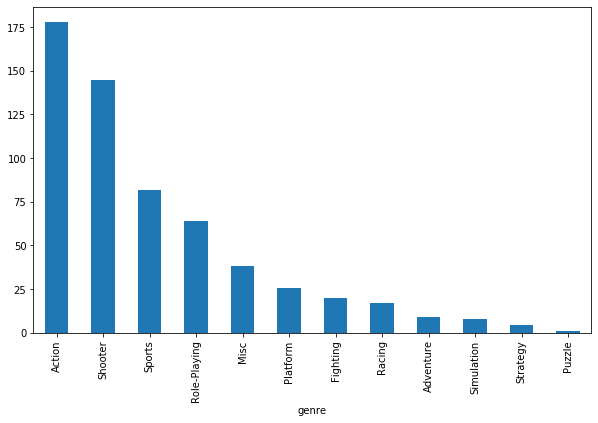

In [63]:
plt.figure(figsize=(10, 6))
games_actual.groupby('genre').na_sales.sum().sort_values(ascending=False).plot(kind='bar')
plt.show()

Очень похоже на ситуацию с жанрами в целом по миру. В лидерах "экшн", "стрелялки", спортивные и ролевые игры. По всей видимости, Америка - законодатель моды в жанрах.

**Европа**

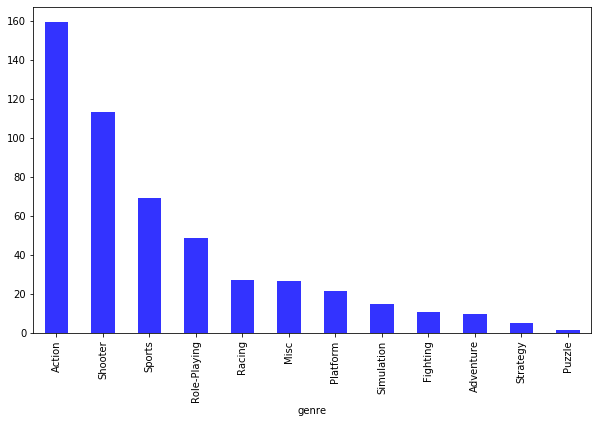

In [64]:
plt.figure(figsize=(10, 6))
games_actual.groupby('genre').eu_sales.sum().sort_values(ascending=False).plot(kind='bar', color='blue', alpha=0.8)
plt.show()

То же распределение, что в Америке и в мире. Но, помимо прочего, в Европе любят автомобили и всё, что с ними связано. По соседству с "большой четвёркой" расположились гоночные игры.

**Япония**

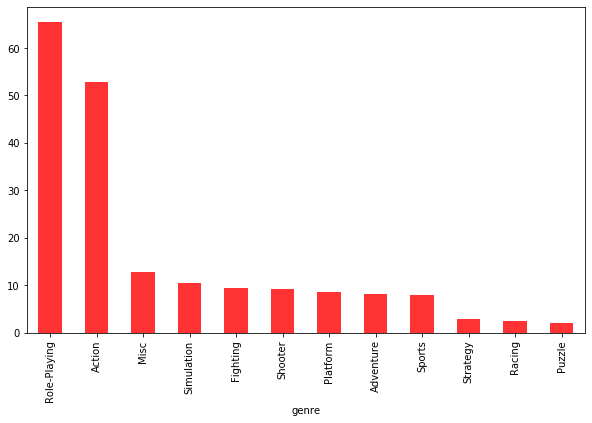

In [65]:
plt.figure(figsize=(10, 6))
games_actual.groupby('genre').jp_sales.sum().sort_values(ascending=False).plot(kind='bar', color='red', alpha=0.8)
plt.show()

Здесь в безоговорочных лидерах всего два жанра - "ролёвки" и "экшн". Жанр ролевых игр в Японии особенно популярен. Даже есть всемирно известный подвид - JRPG (Японская ролевая игра).

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

**Северная Америка**.

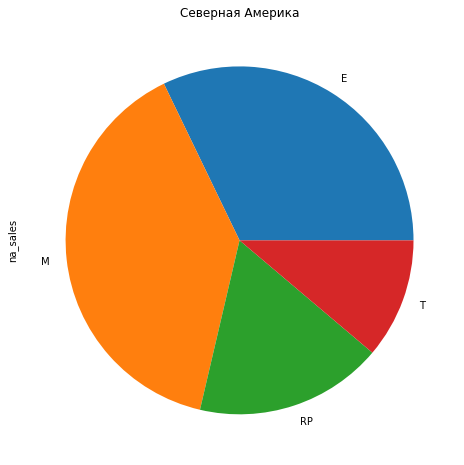

In [66]:
plt.figure(figsize=(8, 8))
games_actual.groupby('rating').na_sales.sum().plot(kind='pie')
plt.title('Северная Америка')
plt.show()

Наибольшая часть рынка - это игры для взрослых (рейтинг "М") и игры для широкой аудитории (рейтинг "Е").

**Европа**

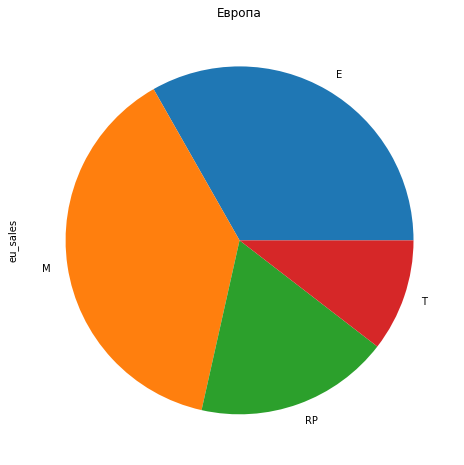

In [67]:
plt.figure(figsize=(8, 8))
games_actual.groupby('rating').eu_sales.sum().plot(kind='pie')
plt.title('Европа')
plt.show()

В Европе, практически такое же распределение, как и в Северной Америке - игры для взрослых, игры для всех.

**Япония**

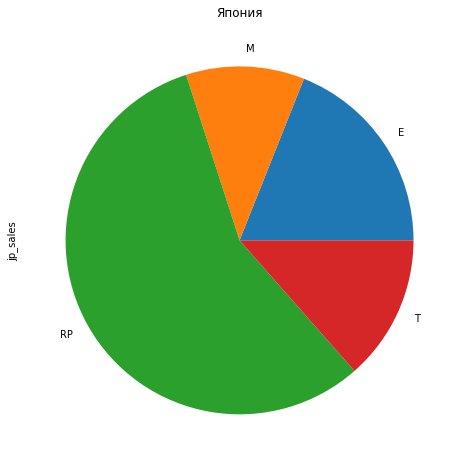

In [68]:
plt.figure(figsize=(8, 8))
games_actual.groupby('rating').jp_sales.sum().plot(kind='pie')
plt.title('Япония')
plt.show()

Либо в Японии не действует рейтинг ESRB, либо на местном рынке присутствует иной критерий оценки игр. Основная часть продаж - игры без рейтинга.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Для начала, сформулируем нулевую и альтернативную гипотезы:

- H₀ - средние пользовательские рейтинги платформ Xbox One и PC **не различаются**

- H₁ - средние пользовательские рейтинги платформ Xbox One и PC **различаются**

Смотрим **дисперсии** выборок по платформам.

In [69]:
xone_data_score = xone_data.loc[xone_data.user_score > 0]
pc_data_score = pc_data.loc[pc_data.user_score > 0]

In [70]:
np.var(xone_data_score.user_score)

1.7855118457300279

In [71]:
np.var(pc_data_score.user_score)

2.6741565100878666

Зададим **критический уровень значимости alpha - 5%**. Если p-value окажется меньше него - отвергнем нулевую гипотезу.

In [72]:
alpha = 0.05

#Поскольку, дисперсии выборок различаются, ставим параметр equal_var=False
results = st.ttest_ind(xone_data_score.user_score, pc_data_score.user_score, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.5926561176517491
Не получилось отвергнуть нулевую гипотезу


**Отвергнуть нулевую гипотезу не получилось**. Средние пользовательские рейтинги платформ Xbox One и PC **не различаются**.

Полученное значение p-value говорит нам о том, что схожесть в средней оценке пользователей, не случайна. На основании этого, можно сделать вывод о статистически значимом равенстве оценок.

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

- H₀ - средние пользовательские рейтинги жанров Action и Sports **не различаются**.

- H₁ - средние пользовательские рейтинги жанров Action и Sports **различаются**.

Посмотрим дисперсии выборок.

In [73]:
games_action = games_actual.loc[(games_actual.user_score > 0) & (games_actual.genre == 'Action')]
games_sports = games_actual.loc[(games_actual.user_score > 0) & (games_actual.genre == 'Sports')]

In [74]:
np.var(games_action.user_score)

1.7476152584876543

In [75]:
np.var(games_sports.user_score)

1.9718042351994367

Зададим критический уровень значимости alpha - 5%. Если p-value окажется меньше него - отвергнем нулевую гипотезу.

In [76]:
alpha = 0.05

#Поскольку, дисперсии выборок различаются, ставим параметр equal_var=False
results = st.ttest_ind(games_action.user_score, games_sports.user_score, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 5.858072645452818e-14
Отвергаем нулевую гипотезу


**P-значение** меньше критического уровня значимости. **Отвергаем нулевую гипотезу**. Средние пользовательские рейтинги жанров Action и Sports **различаются**.

## Вывод

Интернет-магазин «Стримчик», который продаёт по всему миру компьютерные игры, попросил выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Мы проанализировали данные о продажах игр с 1980 по 2016 годы и пришли к выводам:

- основной подъём рынка электронных развлечений начался в 1995 году, после выхода игровой консоли Sony PlayStation
- средняя "жизнь" игровой платформы составляет около пяти лет (за исключением персонального компьютера)
- отзывы критиков и пользователей, практически не влияют на продажи игр
- самые прибыльные жанры Action, Shooter, Sports и Role-Playing Games

Составили портрет пользователя каждого из представленных регионов:

- в Северной Америке, рынок делят поровну консоли-флагманы обоих поколений от Sony и Microsoft - линейка PlayStation и XBox. Любопытно, что продажи консолей от Microsoft, составляют здесь больше половины мирового рынка
- в Европе, первенство занимают консоли PlayStation, предыдущего и нынешнего поколений
- Японский рынок занят только представителями местных компаний - Nintendo и Sony. Огромной популярностью пользуются портативные консоли
- в Америке и Европе самые популярные жанры не отличаются от мировых: Action, Shooter, Sports и Role-Playing Games
- в Японии безоговорочно лидируют Role-Playing Games
- рейтинг ESRB одинаково влияет на распределение продаж в Европе и Америке, где в топе находятся игры для взрослой, 18+ аудитории и игры для всех
- по всей видимости, в Японии не действует рейтинг ESRB, или игры оцениваются здесь другим способом. Подавляющее большинство - игры без рейтинга

Чтобы понять, являются ли оценки пользователей внутри жанров и платформ статистически значимыми, мы провели статистические тесты и выяснили:

- средние пользовательские рейтинги платформ Xbox One и PC не различаются. (Хоть проверка гипотез и не является доказательным инструментом, но тут чётко видна закономерность: обе платформы - детище компании Microsoft. Игры, выходящие на одной платформе, как правило, выходят и на другой)
- средние пользовательские рейтинги наиболее популярных жанров Action и Sports различаются.

На следующий год, магазину «Стримчик» следует делать ставку на консоли нового поколения - PlayStaion 4 и Xbox One. Не забывать про нишевый, но очень стабильный рынок игр для персонального компьютера. В эпоху всеобщей мобильности устройств, необходимо иметь представительный выбор продуктов для портативных консолей. Также, будет не лишним иметь запас игр-хитов с консолей предыдущего поколения - они всё ещё пользуются спросом.

Среди рейтингов, приглядеться к играм с отметками "М" и "Е"; и жанрам - Action, Shooter, Sports и Role-Playing Games, которые так милы сердцу пользователей.